##Preamble:
We'll need scipy.stats for this analysis, as well as seaborn for pretty plots.

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy.stats as stats
import pandas as pd

%matplotlib inline
sns.set_palette('muted')
sns.set_style('darkgrid')

##Likelihood ratio tests with assymetric costs:
We have two equally likely stimuli s1, and s2, and the given responses of a neuron for each stimuli below. Their curves are Gaussian with 

s1: $\mu = 5$ and $\sigma = 0.5$

s2: $\mu = 7$ and $\sigma = 1$

We want to measure the neuron's firing rate and infer which stimulus elicited the response; however, it is **twice as costly** to mistakenly think the stimulus was s2 than it is to mistakenly think the stimulus was s1.

In [2]:
#define domain
x_vals = np.linspace(0, 12,  100)
#compute distributions from scipy.stats normpdf 
s1=stats.norm.pdf(x_vals,loc=5,scale=0.5) #mean 5, std 0.5
s2=stats.norm.pdf(x_vals,loc=7,scale=1) #mean 7, std 1

Let's plot the distributions to see how they look. We also have 4 options to choose where to put our firing rate threshold (vertical lines plotted below). This is where we need to take into account the increased penalty in incorrectly choosing s2.

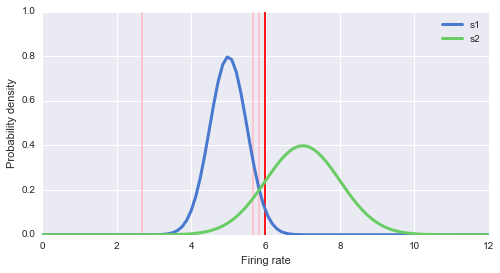

In [3]:
plt.figure(figsize=(8,4), dpi=100)
sns.plt.plot(x_vals,s1,linewidth=3)
sns.plt.plot(x_vals,s2,linewidth=3)
plt.legend(['s1','s2'])
plt.ylabel('Probability density')
plt.xlabel('Firing rate')

potential_thresholds = np.array([2.69,5.667,5.830,5.978]) #possible firing rate thresholds

sns.plt.vlines(potential_thresholds,0,1,color='pink') #plot 4 possible thresholds
sns.plt.vlines(5.978,0,1,color='red') #plot the one I think is the correct threshold

If we are penalized 2x as much for incorrectly choosing s2, then we'd expect to set the threshold right of the intersection of the distributions, so as to guess s1 more often than s2. The optimal choice of these 4 options would be the red line. 

##Information Theory:
###Bernoulli entropy
Given a Bernoulli firing neuron, what is the entropy of this neuron's firing rate distribution (F=0 if not firing, F=1 if firing) if the probability of firing P(F=1)=0.1, and P(F=0)=0.9?

\begin{eqnarray}
H &=& -\sum_{F=0}^{1} P(F)\log_2(P(F))\\
&=& - P(F=0)\log_2(P(F=0)) - P(F=1)\log_2(P(F=1))\\
&=& -0.9\log_2(0.9) - 0.1\log_2(0.1)\\
&=& \textbf{0.4690}
\end{eqnarray}

An easy way to visualize this is to plot the Bernoulli entropy as a function of success probability, and see what H(F) is when P(F=1)=0.1.

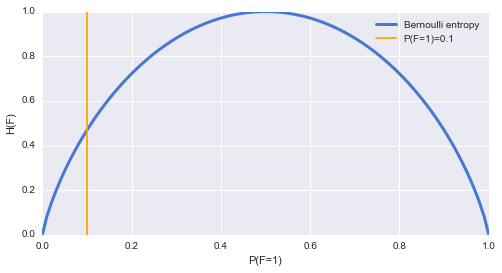

In [4]:
#compute the entropy for success probabilities 0-1
xx = np.linspace(0, 1,  100)
bernoulli_entropy=[]
for prob in xx:
    bernoulli_entropy.append(stats.bernoulli.entropy(p=prob)) 

#plot the entropy function and divide by log(2) bc this entropy is base e and we want base 2    
plt.figure(figsize=(8,4), dpi=100)
sns.plt.plot(xx,np.array(bernoulli_entropy)/np.log(2),linewidth=3)  
plt.axvline(0.1,color='orange')
plt.ylabel('H(F)')
plt.xlabel('P(F=1)')
plt.legend(['Bernoulli entropy','P(F=1)=0.1'],loc='best')

The pink line intersects at approximately H(F)=0.47.

###Mutual information:
We add a stimulus $S$ now that flashes with a probability of 0.1 in a given time period. If there is a flash, the neuron will fire with probability 1/2. If there is no flash, the neuron will fire with probability 1/18. $F$ is gain the firing random variable. What is the mutual information $MI(S,F)$?

Mutual information is the difference between the total response entropy and the average response entropy on trials that involve repetitive presentation of the same stimulus. The entropy of a response to a given stimulus is

\begin{equation}
H_s = -\sum_r P[r|s]\log_2P[r|s].
\end{equation}

Averaging this quantity over all stimuli yields the noise entropy, associated with the response variability not due to changes in the stimulus

\begin{equation}
H_{noise} = \sum_s P[s]H_s = -\sum_{s,r} P[s] P[r|s] \log_2P[r|s].
\end{equation}

We obtain mutual information by subtracting the noise entropy from the full response entropy

\begin{equation}
I_m = H - H_{noise} = -\sum_r P[r]\log_2P[r] + \sum_{s,r}P[s]P[r|s]\log_2P[r|s].
\end{equation}


Call S=1 stimulus on, S=0 stimulus off, F=1 neuron firing, F=0 neuron not firing. We thus have

\begin{eqnarray}
P[F=1|S=1]=1/2 &\text{ and }& P[F=0|S=1]=1/2\\
P[F=1|S=0]=1/18 &\text{ and }& P[F=0|S=0]=17/18\\
P[S=1]=1/10 &\text{ and }& P[S=0] = 9/10\\
\end{eqnarray}

We already know $H$ from earlier is **0.4690**, so now we need to compute

\begin{eqnarray}
I_m = H - H_{noise} &=& 0.469 + \sum_{s,r}P[s]P[r|s]\log_2P[r|s]\\
&=& 0.469 + P[0]P[0|0]\log_2P[0|0] +  P[1]P[0|1]\log_2P[0|1] + \\
&& P[0]P[1|0]\log_2P[1|0] + P[1]P[1|1]\log_2P[1|1]\\
&=& 0.469 + \frac{9}{10}\frac{17}{18}\log_2\frac{17}{18} + \frac{1}{10}\frac{1}{2}\log_2\frac{1}{2} + \frac{9}{10}\frac{1}{18}\log_2\frac{1}{18} + \frac{1}{10}\frac{1}{2}\log_2\frac{1}{2}\\
&=& 0.469-0.3786\\
&=&\textbf{0.904}
\end{eqnarray}
as calculated below.

In [5]:
0.469 + 9/10*17/18*np.log2(17/18) + 1/10*1/2*np.log2(1/2) + 9/10*1/18*np.log2(1/18) + 1/10*1/2*np.log2(1/2)

0.090410913764707293

##Simulated tuning data:
We are given 4 cricket cercal organ neurons' firing rates x 100 trials for 24 stimuli directions. First let's load the data.

In [6]:
with open('tuning.pickle', 'rb') as f:
    data = pickle.load(f)

stimulus=data['stim']    
neuron1=data['neuron1']
neuron2=data['neuron2']
neuron3=data['neuron3']
neuron4=data['neuron4']

Let's plot the tuning curves to see what the data looks like.

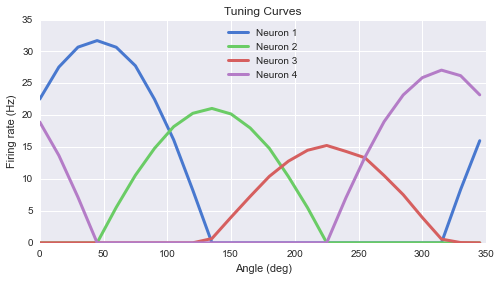

In [7]:
plt.figure(figsize=(8,4), dpi=100)
plt.plot(stimulus,neuron1.mean(axis=0),stimulus,neuron2.mean(axis=0),
         stimulus,neuron3.mean(axis=0),stimulus,neuron4.mean(axis=0),linewidth=3)
plt.legend(['Neuron 1','Neuron 2','Neuron 3','Neuron 4'],loc='best')
plt.xlabel('Angle (deg)')
plt.ylabel('Firing rate (Hz)')
plt.title('Tuning Curves')

These individual neurons have half-wave rectified cosine shaped tuning curves tuned for different directions conveniently 90 degrees apart (45, 135, 225, 315 degrees).

###Testing for a Poisson Process:
One of these 4 neurons is not undergoing a Poisson process, whereas the other 3 are. How do we determine which one of these are **not** Poisson? 

We know that for a Poisson process, the Fano factor should be exactly 1. So we can **test each neuron's Fano factor**.

\begin{equation}
\text{Fano} =\frac{Var(x)}{E[X]} = \frac{\sigma^2}{\mu}
\end{equation}

These mean firing rates were computed over 10s. So we can multiply by 10 to get # of spikes. We could also just compute the Fano factor from the mean firing rates using

\begin{equation}
\text{Fano}_{Firing} = \frac{a^2\sigma^2}{a\mu} = a\frac{\sigma^2}{\mu} = a \left(\text{Fano}_{Spikes}\right)
\end{equation}

where $a$ is $\frac{1}{10}$, since we are taking the number of spikes in 10 seconds and computing the mean firing rate per second.

In [8]:
#Get spikes from firing rates
spikes1=neuron1*10
spikes2=neuron2*10
spikes3=neuron3*10
spikes4=neuron4*10

#compute fano factors
fano1 = spikes1.var(axis=0)/spikes1.mean(axis=0)
fano2 = spikes2.var(axis=0)/spikes2.mean(axis=0)
fano3 = spikes3.var(axis=0)/spikes3.mean(axis=0)
fano4 = spikes4.var(axis=0)/spikes4.mean(axis=0)

#throw it into a dataframe for nice visualization
df=pd.DataFrame({'Fano 1':fano1,'Fano 2':fano2,'Fano 3':fano3,'Fano 4':fano4},index=stimulus)
df.index.name='Stimulus orientation'

df[0:180] #show half the table

,Fano 1,Fano 2,Fano 3,Fano 4
Stimulus orientation,,,,
0,0.848285,NaN,NaN,1.103339
15,1.026110,NaN,NaN,0.891540
30,1.073571,NaN,NaN,1.044094
45,1.017205,NaN,NaN,NaN
60,0.979097,1.015468,NaN,NaN
75,0.756161,1.079236,NaN,NaN
90,0.930582,0.996164,NaN,NaN
105,0.834098,0.875186,NaN,NaN
120,0.786562,0.972798,NaN,NaN


We can see which neurons look Poisson by examining each column in this dataframe. NaN values are due to 0 mean firing rates so we can ignore those. Neurons 1, 2, and 4 have Fano factors that are relatively close to 1, but clearly **neuron 3 is not Poisson spiking** because its Fano factors deviate greatly from 1.

###Population decoding:
Each of the neurons were exposed to a single stimulus of unknown direction for 10 trials x 10 seconds. r1-r4 are the neurons firing rates (Hz) to the unknown direction. c1-c4 are basis vectors for neurons 1-4. Using the Tuning data from above, let's decode which at which angle the population vector is pointing.

In [9]:
with open('pop_coding.pickle', 'rb') as f:
    pop_coding = pickle.load(f)
pop_coding

{'c1': array([ 0.70710678,  0.70710678]),
 'c2': array([ 0.70710678, -0.70710678]),
 'c3': array([-0.70710678, -0.70710678]),
 'c4': array([-0.70710678,  0.70710678]),
 'r1': array([ 11.9,  12.8,  13.9,  12.1,  11.3,  12.2,  12.9,  12.4,  13.2,  10.7]),
 'r2': array([ 18.8,  18. ,  19. ,  19.1,  18.1,  21.5,  20.3,  21.2,  18.6,  20.4]),
 'r3': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'r4': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

Right away we see that r2>r1 and r3=r4=0 for each trial. The stimulus angle is probably around preferred angle for neuron 2. Let's compute rmax for each neuron. We will divide the mean firing rates obtained during these mystery trials by the max firing rate to get the appropriate weights.

In [10]:
#find the maximum firing rates
rmax1=neuron1.mean(axis=0).max()
rmax2=neuron2.mean(axis=0).max()
rmax3=neuron3.mean(axis=0).max()
rmax4=neuron4.mean(axis=0).max()

#find mean firing rate for mystery trials
r1=pop_coding['r1'].mean()
r2=pop_coding['r2'].mean()
r3=pop_coding['r3'].mean()
r4=pop_coding['r4'].mean()

We don't even need to worry about neurons 3 or 4 since their responses are 0. Let's add the vectors for Neurons 1 and 2. 0 degrees represents North, 90 degrees East, etc., which is why the basis vectors seem to have unconventional directions (c2 points in the bottom right quadrant for example).

In [11]:
#define weights for each neuron's firing
weight1=r1/rmax1
weight2=r2/rmax2

#get the neuron's basis vectors
c1=pop_coding['c1']
c2=pop_coding['c2']

#sum the vectors
summed=weight1*c1+weight2*c2

#compute angle relative to x-axis
angle_temp=np.arctan(summed[1]/summed[0]) * 180/np.pi #convert to degrees

#convert to angle relative to y-axis
if angle_temp < 0:
    angle = np.mod(90+np.abs(angle_temp),360)
else:
    angle = np.mod(90+angle_temp,360)

print repr(angle) + " degrees"

112.1930900035492 degrees


The direction of the population vector is a little north of south-east at $\textbf{112}^o$. Let's plot the activities below to better visualize what's happening. Remember Neurons 3 and 4 do not contribute to this population vector so we can ignore them.

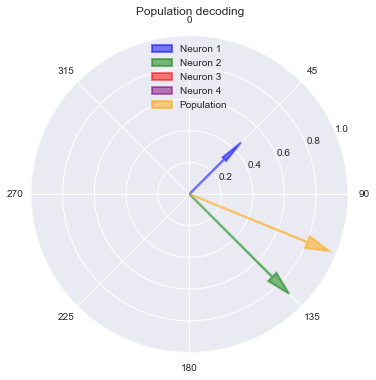

In [12]:
fig = plt.figure(figsize=(5.5, 5.5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.set_xticklabels([90,45,0,315,270,225,180,135])

vec1 = plt.arrow(45/180.*np.pi, 0, 0, weight1*0.8, alpha = 0.5, width = 0.005,
                  edgecolor='blue',facecolor = 'blue', lw = 2, zorder = 1)

vec2 = plt.arrow(-45/180.*np.pi, 0, 0, weight2*0.8, alpha = 0.5, width = 0.005,
                  edgecolor='green',facecolor = 'green', lw = 2, zorder = 1)

vec3 = plt.arrow(135/180.*np.pi, 0, 0, 0*0.8, alpha = 0.5, width = 0.005,
                  edgecolor='red',facecolor = 'red', lw = 2, zorder = 1)

vec4 = plt.arrow(225/180.*np.pi, 0, 0, 0*0.8, alpha = 0.5, width = 0.005,
                  edgecolor='purple',facecolor = 'purple', lw = 2, zorder = 1)

popWeight = np.linalg.norm(summed) #magnitude of the population vector (turns out to be 1)

popVec = plt.arrow(angle_temp/180.*np.pi, 0, 0, popWeight*0.8, alpha = 0.5, width = 0.005,
                  edgecolor='orange',facecolor = 'orange', lw = 2, zorder = 1)
plt.legend([vec1, vec2,vec3,vec4,popVec], ['Neuron 1', 'Neuron 2','Neuron 3','Neuron 4','Population'],loc='upper center')
plt.title('Population decoding')

We can now visualize how neurons 3 and 4 do not contribute to the population vector.